In [2]:
import math, random
from tqdm.notebook import tqdm
from tabulate import tabulate
from unidecode import unidecode
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import pandas as pd
from omnibelt import save_yaml, load_json, save_json
import omnifig as fig
from stox import misc
from stox.general import load_symbol_table
# from stox.ibkr import 
fig.initialize()

In [3]:
symbols_table = load_symbol_table()
eur = {yfsym: info for yfsym, info in symbols_table.items() if info['ibkr-contract']['currency'] == 'EUR'}
len(symbols_table), len(eur)

(454, 239)

In [7]:
date = 'last'
config = fig.create_config('container', api={'_type': 'ib-extractor', 'using_notebook': True, 'client_id': 14}, 
						   currency='USD', exchange=['NYSE', 'NASDAQ'], return_all=True)
_container_source = config.peek('container')
def create_container(yfsym):
	with _container_source.silence():
		ctx = _container_source.create()
	ctx['ticker'] = yfsym
	ctx['date'] = date
	return ctx
def search(query):
	config.push('query', misc.clean_company_name(query))
	cts = fig.run_script('ib-search', config)
	return cts
def view(cts):
	print(tabulate([(i, c.symbol, c.currency, c.primaryExchange, c.conId, c.description) for i, c in reversed(list(enumerate(cts)))], headers=['index', 'symbol', 'currency', 'exchange', 'conId', 'description']))
config.silent = True
ibe = config.pull('api')

ERROR:ib_insync.wrapper: Error 321, reqId 2147483647: Error validating request.-'cG' : cause - The API interface is currently in Read-Only mode.
ERROR:ib_insync.wrapper: Error 321, reqId -1: Error validating request.-'ce' : cause - The API interface is currently in Read-Only mode.
ERROR:ib_insync.ib: open orders request timed out
ERROR:ib_insync.ib: completed orders request timed out


In [6]:
todo = [yfsym for yfsym, info in eur.items() if 'partners' not in info]
# yfsym = random.choice(todo)
# ctx = create_container(yfsym)
# yfsym, symbols_table[yfsym]['ibkr-contract']['symbol'], ctx['company_short_name'], ctx['country'], ctx['sector']
len(todo)

239

In [7]:
table_path = misc.assets_root() / 'euro-partners.json'
table = load_json(table_path) if table_path.exists() else {}
contexts = {yfsym: create_container(yfsym) for yfsym in todo}
len(table)

238

In [8]:
sols = {}
bad = {}

In [9]:
itr = tqdm(todo)
for yfsym in itr:
	if yfsym in sols or yfsym in bad or yfsym in table:
		continue
	itr.set_description(f'{yfsym} (bad={len(bad)})')
	
	if yfsym not in contexts:
		contexts[yfsym] = create_container(yfsym)
	ctx = contexts[yfsym]
	
	try:
		long_name = unidecode(ctx['company_name'])
		company_name = unidecode(ctx['company_short_name'])
		assert company_name is not None
	except Exception as e:
		bad[yfsym] = e
	else:
		ibsym = symbols_table[yfsym]['ibkr-contract']['symbol']
		srcs = [search(ibsym), search(company_name)]
		try:
			if long_name is not None and misc.clean_company_name(long_name) != misc.clean_company_name(company_name):
				srcs.append(search(long_name))
		except:
			print(f'Error searching {yfsym}: {long_name!r}')
			raise
		srcs = [[ct for ct in src if ct.currency == 'USD'] for src in srcs]
		locs = [{ct.conId for ct in src} for src in srcs]
		cts = []
		for src in srcs:
			cts.extend(ct for ct in src if ct not in cts)
		
		def contract_score(ct):
			return (sum(ct.conId in loc for loc in locs),
				max(misc.str_similarity(long_name.lower(), ct.description.lower()), 
					misc.str_similarity(company_name.lower(), ct.description.lower())))
		picks = sorted([ct for ct in cts if ct.currency == 'USD'], key=contract_score, reverse=True)
		
		sols[yfsym] = picks
len(sols), len(bad)

  0%|          | 0/239 [00:00<?, ?it/s]

(0, 1)

In [10]:
print(tabulate([[yfsym, repr(e)] for yfsym, e in bad.items()], headers=['symbol', 'error']))

symbol     error
---------  -------------------------------------------------------------
NDA-FI.HE  AttributeError("'NoneType' object has no attribute 'encode'")


In [11]:
table.update({
	# scores[yfsym], 
	yfsym: {
	'country': contexts[yfsym]['country'], 
	'sector': contexts[yfsym]['sector'],
	'market_cap': [contexts[yfsym]['market_cap'].amount, contexts[yfsym]['market_cap'].unit],
	'company_name': contexts[yfsym]['company_short_name'], 
		'long_name': contexts[yfsym]['company_name'],
	'ibkr-symbol': symbols_table[yfsym]['ibkr-contract']['symbol'],
	'results': [{'symbol': c.symbol, 'description': c.description, 'conId': c.conId, 'currency': c.currency, 'primaryExchange': c.primaryExchange, 'exchange': c.exchange} for c in cts],
	}
				for yfsym, cts in sols.items()})
# if len(table) > 0:
# 	save_json(table, misc.assets_root() / 'euro-partners.json')
len(table)

238

In [12]:
# print(tabulate([(i, c.symbol, c.currency, c.primaryExchange, c.conId, c.description, contract_score(c)[-1]) for i, c in reversed(list(enumerate(picks)))], headers=['index', 'symbol', 'currency', 'exchange', 'conId', 'description', 'score']))

In [13]:
def best_match_score(base: str, *options: str):
	return max(misc.str_similarity(base.lower(), opt.lower()) for opt in options)

In [14]:
scores = {yfsym: best_match_score(
	misc.clean_company_name(entry['results'][0]['description']), 
	misc.clean_company_name(contexts[yfsym]['company_name']),
	misc.clean_company_name(contexts[yfsym]['company_short_name']),
) for yfsym, entry in table.items() if len(entry['results']) > 0}
pts = list(scores.values())
len(pts)

212

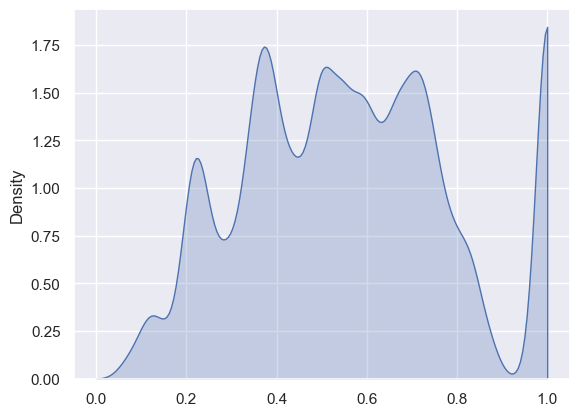

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
# %matplotlib inline
# sns.displot(pts, bins=50);
sns.kdeplot(pts, bw_adjust=0.3, fill=True, clip=(0, 1));

In [15]:
picks = {}

In [34]:
def display_results(name, results):
	top = results[:5]
	
	res = [
		f'({i}) {r["description"]!r} :: {r["symbol"]} [{s:.2f}]'
		for i, (r, s) in enumerate(sorted([(r, best_match_score(name, misc.clean_company_name(r['description']))) for r in top], key=lambda x: x[1], reverse=True))]
	return '\n'.join(res)
	res = [(misc.clean_company_name(r['description']), f'{best_match_score(name, r["description"]):.2f}', r['description'][:60]) for r in top]
	res = sorted(res, key=lambda r: float(r[1]), reverse=True)
	return '\n'.join(tabulate(res).split('\n')[1:-1])

In [35]:
rows = [[entry['company_name'], misc.clean_company_name(entry['long_name']),
		 picks.get(yfsym, 0),
		 display_results(misc.clean_company_name(entry['long_name']), entry['results']),
		 yfsym, entry['country'], entry['sector'], misc.humanize(entry['market_cap'][0]), ] 
		for yfsym, entry in table.items() if len(entry['results']) > 0]
len(rows)

212

In [36]:
df = pd.DataFrame(rows, columns=['company', 'long_name', 'pick', 'ibkr-desc', 'symbol', 'country', 'sector', 'market_cap'])

In [38]:
# import pandasgui
# pandasgui.show(df);
import dtale
dt = dtale.show(df)
dt.open_browser()
# print(dt._main_url)

In [33]:
# picks = dt.data['pick']

In [40]:
picks = {yfsym: int(p) for yfsym, p in zip(dt.data['symbol'], dt.data['pick']) if not math.isnan(p)}
# manual = {'IAG.MC': 'ICAGY', 'LHA.DE':'DLAKY', 'OR.PA': 'LRLCY', 'PST.MI': 'PITAF', 'SGO.PA': 'CODYY', 'SOF.BR': 'SFNXF', 'SU.PA': 'SBGSY', 'VOW3.DE': 'VWAPY'}

In [41]:
failed = [yfsym for yfsym, idx in picks.items() if idx < 0]

In [42]:
done = {yfsym: table[yfsym]['results'][idx] for yfsym, idx in picks.items() if idx >= 0}
len(done)

184

In [43]:
# save_json(done, misc.assets_root() / 'euro-partners-matches.json')

In [45]:
from stox.ibkr import add_symbol_row, save_symbol_table

In [46]:
symbols_table = load_symbol_table()

In [47]:
for yfsym, info in done.items():
	# add_symbol_row(yfsym, info)
	ibsym = info['symbol']
	if ibsym not in symbols_table:
		symbols_table[ibsym] = {'ibkr-contract': info, 'partners': [yfsym]}
	elif yfsym not in symbols_table[ibsym].get('partners', []):
		symbols_table[ibsym].setdefault('partners', []).append(yfsym)
	if ibsym not in symbols_table[yfsym].get('partners', []):
		symbols_table[yfsym].setdefault('partners', []).append(ibsym)

In [48]:
# save_symbol_table(symbols_table)

WindowsPath('C:/Users/anwan/OneDrive/Khan/projects/stox/assets/symbol-table.yml')

In [27]:

len(table)
# print(tabulate(table, headers=['symbol', 'country', 'company', 'euro', 'score', 'ibkr','ibkr-desc']))

238

In [28]:

# save_json(table, misc.assets_root() / 'euro-partners.json')

In [19]:
df = pd.DataFrame(table, columns=['score', 'symbol', 'country', 'sector', 'market_cap', 'company', 'ibkr', 'results'])
# df.to_csv(misc.assets_root() / 'ibkr-company-matches.csv');

In [22]:
import dtale
dtale.show(df);

In [30]:
from stox.ibkr import add_symbol_row, save_symbol_table

In [17]:
symbols_table = load_symbol_table()

In [18]:
# entry = symbols_table['RACE']['ibkr-contract']
# entry

In [5]:
# from stox.ibkr import Stock
# ct = Stock(**entry)
# ct

In [31]:
# save_symbol_table(symbols_table)

WindowsPath('C:/Users/anwan/OneDrive/Khan/projects/stox/assets/symbol-table.yml')